In [4]:
import scanpy as sc
import scanpy.external as sce
import anndata
from pathlib import Path
from tqdm import tqdm
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from upsetplot import UpSet
from upsetplot import from_contents

In [6]:
#import relation_data_lake as rdl

In [7]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

In [8]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [9]:
from scipy import stats

In [10]:
import scipy.sparse as sp
import anndata as ad

In [11]:
import json

import dask.dataframe as dd
import numpy as np
import pandas as pd
#import relation_data_lake as rdl
import scanpy as sc
import scipy.sparse as sp
from anndata import AnnData
#from relation_data_lake.aws.aws_api import pull_folder

In [12]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=400, figsize = [1.5*6.4, 1.5*4.8])
sns.set_style("whitegrid")

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
n_jobs = 50

sc._settings.ScanpyConfig(
    n_jobs=n_jobs
)

In [15]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection

def heatmap_circle(input_colors, input_sizes, fig_size = (20,10),
                   row_cluster=True, col_cluster=True, 
                   cluster_on="color", method="ward", vmin=None, vmax=None,
                   cmap="RdBu_r"): #color = DEG, size = significance p-value

    if input_colors.shape != input_sizes.shape:
        raise InputError("Input matrices must be the same shape.")
    if all(input_colors.index == input_sizes.index) == False:
        raise InputError("Input indexes and order must be equal.")
    if all(input_colors.columns == input_sizes.columns) == False:
        raise InputError("Input columns and order must be equal.")
    
    
    if cluster_on=="color":
        clustergrid = sb.clustermap(input_colors,cmap="RdBu_r",
                                    row_cluster=row_cluster,col_cluster=col_cluster, method=method)
        row_order = clustergrid.dendrogram_row.reordered_ind if row_cluster else range(len(input_colors.index))
        col_order = clustergrid.dendrogram_col.reordered_ind if col_cluster else range(len(input_colors.columns))
        input_colors = input_colors.iloc[row_order,col_order]
        input_sizes = input_sizes.iloc[row_order,col_order]
        plt.clf()
    elif cluster_on=="size":
        clustergrid = sb.clustermap(input_sizes,cmap="RdBu_r",
                                    row_cluster=row_cluster,col_cluster=col_cluster, method=method)
        row_order = clustergrid.dendrogram_row.reordered_ind if row_cluster else range(len(input_colors.index))
        col_order = clustergrid.dendrogram_col.reordered_ind if col_cluster else range(len(input_colors.columns))
        input_colors = input_colors.iloc[row_order,col_order]
        input_sizes = input_sizes.iloc[row_order,col_order]
        plt.clf()
        
    #plt.figure()
    fig, ax = plt.subplots(figsize=fig_size)
    
    

    N,M = input_colors.shape
    ylabels = list(input_colors.index)
    xlabels = list(input_colors.columns)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    s = input_sizes.values #size column
    c = input_colors.values

    R = s/s.max()/2
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=c.flatten(), cmap=cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax))
    ax.add_collection(col)

    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    #ax.grid(which='minor')

    ax.set_facecolor((1,1,1,0))
    plt.grid(None)
    fig.colorbar(col)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.setp(ax.get_xticklabels(), rotation=90,ha="right")


# Load data and create objects

In [16]:
adata = sc.read_h5ad('../Rd13_Data_post_filtering_cell_types-reseq.h5ad.gzip')
adata.obs['unique_state'] = adata.obs.condition.astype('str') + '-' + adata.obs.target.astype('str')
#adata.uns['log1p']["base"] = None

In [17]:
adata_Rd3 = adata[adata.obs.rep == 'New'].copy()
adata_Rd1 = adata[adata.obs.rep == 'Old'].copy()

In [18]:
adata_Rd3_T = adata_Rd3[adata_Rd3.obs.condition == 'Tgfb1'].copy()
adata_I = adata_Rd3[adata_Rd3.obs.condition == 'Il1b'].copy()
adata_Rd3_R = adata_Rd3[adata_Rd3.obs.condition == 'Resting'].copy()
adata_Rd3_NTC = adata_Rd3[adata_Rd3.obs.target == 'non-targeting'].copy()

adata_Rd1_T = adata_Rd1[adata_Rd1.obs.condition == 'Tgfb1'].copy()
adata_Rd1_R = adata_Rd1[adata_Rd1.obs.condition == 'Resting'].copy()
adata_Rd1_NTC = adata_Rd1[adata_Rd1.obs.target == 'non-targeting'].copy()

In [19]:
def get_degs(adata, groupby_key, ref_key):
    sc.tl.rank_genes_groups(adata, groupby=groupby_key, reference=ref_key,rankby_abs = True)
    yy = sc.get.rank_genes_groups_df(adata, group = None)
    if ((groupby_key == 'condition')&(ref_key == 'Resting')):
        if ('group' not in yy):
            yy['group'] = 'Tgfb1'
    return yy

def convert_pvals(x):
    scores = x["scores"].mean()
    logfold = x["logfoldchanges"].mean()
    pvals = stats.combine_pvalues(x["pvals"].values).pvalue
    pvals_adj = stats.combine_pvalues(x["pvals_adj"].values).pvalue
    #return {'scores':scores, 'logfc': logfold, 'pvals':pvals, 'pvals_adj':pvals_adj}
    ret_table = pd.Series([scores, logfold, pvals, pvals_adj])
    return ret_table

def combine_rounds(adata_Rd3, adata_Rd1, groupby_key, ref_key):
    yy_Rd3 = get_degs(adata_Rd3, groupby_key, ref_key) 
    yy_Rd1 = get_degs(adata_Rd1, groupby_key, ref_key) 
    yy = pd.concat([yy_Rd3,yy_Rd1],axis=0)
    yy = yy.groupby(['group','names']).apply(convert_pvals)
    yy.columns = ['scores','logfoldchanges','pvals','pvals_adj']
    yy.reset_index(inplace=True)
    return yy



In [20]:
yy_T = combine_rounds(adata_Rd3_T, adata_Rd1_T, 'target', 'non-targeting')
yy_R = combine_rounds(adata_Rd3_R, adata_Rd1_R, 'target', 'non-targeting')
yy_NTC = combine_rounds(adata_Rd3_NTC, adata_Rd1_NTC, 'condition', 'Resting')
yy_I = get_degs(adata_I, 'target', 'non-targeting') 


In [21]:
#yy_R.to_csv('DEG_Resting_Target_vs_NTC.csv')
#yy_T.to_csv('DEG_Tgfb1_Target_vs_NTC.csv')
#yy_I.to_csv('DEG_Il1b_Target_vs_NTC.csv')
#yy_NTC.to_csv('DEG_NTC_Stim_vs_Resting.csv')

In [27]:
yy_T['log_pval'] = -np.log10(yy_T.pvals)
yy_R['log_pval'] = -np.log10(yy_R.pvals)
yy_NTC['log_pval'] = -np.log10(yy_NTC.pvals)
yy_I['log_pval'] = -np.log10(yy_I.pvals)

In [22]:
c_targets = pd.Categorical( adata.obs.target.unique() )
ct_ntc = pd.Series( ['Tgfbr1','Smad3','Wdr82','Hcfc1','Srcap','Kat8','Kat5','Dmap1','Paxip1'] )

In [60]:
def load_up_genes(path, ref_genes, set_num):
    bp_genes = pd.read_csv(path)
    GeneList = pd.Series( pd.concat([bp_genes.iloc[:,set_num]] ).unique() )
    GeneList = GeneList.str.strip()
    GeneList = GeneList.str.capitalize()
    GeneList = GeneList[~GeneList.isna()]
    print('Num of genes already QCd out')
    print( len(GeneList[~GeneList.isin(ref_genes)]  ))
    GeneList = GeneList[GeneList.isin(ref_genes)]
    print('Number of genes to plot')
    print(len(GeneList))
    return GeneList
    
def trim_for_plot(yy, GeneList, ct_ntc):
    yy_tmp = yy.copy()
    yy_tmp = yy_tmp[yy_tmp.names.isin(GeneList)]
    yy_tmp = yy_tmp[yy_tmp.group.isin(ct_ntc)]
    yy_tmp.logfoldchanges[yy_tmp.logfoldchanges < -2.5] = -2.5
    yy_tmp.logfoldchanges[yy_tmp.logfoldchanges >  2.5] =  2.5
    yy_tmp.log_pval[yy_tmp.log_pval > 10] = 10
    return yy_tmp

In [70]:
yy_T_tmp

,group,names,scores,logfoldchanges,pvals,pvals_adj,log_pval
21271,Dmap1,Acta2,-3.220356,-0.665365,1.528411e-05,5.323161e-04,4.815760
21286,Dmap1,Adam12,2.987482,0.685551,1.342767e-04,3.997875e-03,3.871999
21287,Dmap1,Adam15,-2.211037,-0.530723,3.463461e-03,3.199067e-02,2.460490
21292,Dmap1,Adamts10,-0.956619,-0.262338,3.654222e-01,6.669193e-01,0.437205
21294,Dmap1,Adamts14,-1.276639,-0.562525,1.740950e-01,4.521968e-01,0.759214
...,...,...,...,...,...,...,...
142011,Wdr82,Tagln,-6.396762,-1.204656,4.681296e-18,1.907111e-15,10.000000
142054,Wdr82,Tead1,0.811954,0.057352,1.477083e-02,6.720164e-02,1.830595
142055,Wdr82,Tead2,-2.277343,-0.503433,2.119689e-04,1.400932e-03,3.673728
142077,Wdr82,Tgfbr3,1.294155,0.916946,1.020765e-01,3.149439e-01,0.991074


In [71]:
yy_NTC

,group,names,scores,logfoldchanges,pvals,pvals_adj,log_pval
0,Il1b,0610009b22rik,1.207735,0.192487,2.277507e-01,4.205118e-01,0.642540
1,Il1b,0610010k14rik,-3.143436,-0.336886,1.775352e-03,1.113649e-02,2.750716
2,Il1b,0610012g03rik,-2.100807,-0.174923,3.621738e-02,1.184400e-01,1.441083
3,Il1b,1110004f10rik,-3.387117,-0.201924,7.660395e-04,5.556676e-03,3.115749
4,Il1b,1110008p14rik,9.676290,1.085598,3.731020e-20,6.576544e-18,19.428172
...,...,...,...,...,...,...,...
10571,Tgfb1,Zwint,3.054462,0.165076,7.826078e-06,2.829523e-05,5.106456
10572,Tgfb1,Zyg11b,-1.330680,-0.205989,1.331999e-01,2.536785e-01,0.875496
10573,Tgfb1,Zyx,6.659699,0.465834,6.941030e-22,2.140127e-20,21.158576
10574,Tgfb1,Zzef1,0.112959,-0.041347,2.784949e-01,4.067596e-01,0.555183


In [80]:

yy_NTC_tmp

,group,names,scores,logfoldchanges,pvals,pvals_adj,log_pval
5411,Tgfb1 vs. Control NTCs,Actn1,11.468603,0.553682,3.043438e-65,7.316759e-63,10.000000
5874,Tgfb1 vs. Control NTCs,C1qtnf6,-4.987576,-0.715116,1.158725e-11,1.900699e-10,10.000000
5998,Tgfb1 vs. Control NTCs,Cd34,-11.325329,-2.500000,5.694905e-61,1.430822e-58,10.000000
6304,Tgfb1 vs. Control NTCs,Crlf1,2.719985,0.118477,4.397365e-04,1.720325e-03,3.356807
6335,Tgfb1 vs. Control NTCs,Csrp2,18.758169,1.422561,3.891113e-155,1.938405e-151,10.000000
6421,Tgfb1 vs. Control NTCs,Dbi,-19.090446,-0.683662,8.036991e-211,8.984355e-208,10.000000
6516,Tgfb1 vs. Control NTCs,Dkk3,-10.094945,-2.277386,1.915669e-45,3.948427e-43,10.000000
6882,Tgfb1 vs. Control NTCs,Fbln2,-8.409452,-0.351903,1.117487e-36,6.625515e-35,10.000000
6912,Tgfb1 vs. Control NTCs,Fgf7,-14.618787,-2.039972,1.625040e-98,1.805103e-95,10.000000
6975,Tgfb1 vs. Control NTCs,Fth1,-26.393810,-1.165176,4.312303e-295,2.402006e-290,10.000000


Num of genes already QCd out
14
Number of genes to plot
31


<Figure size 800x800 with 0 Axes>

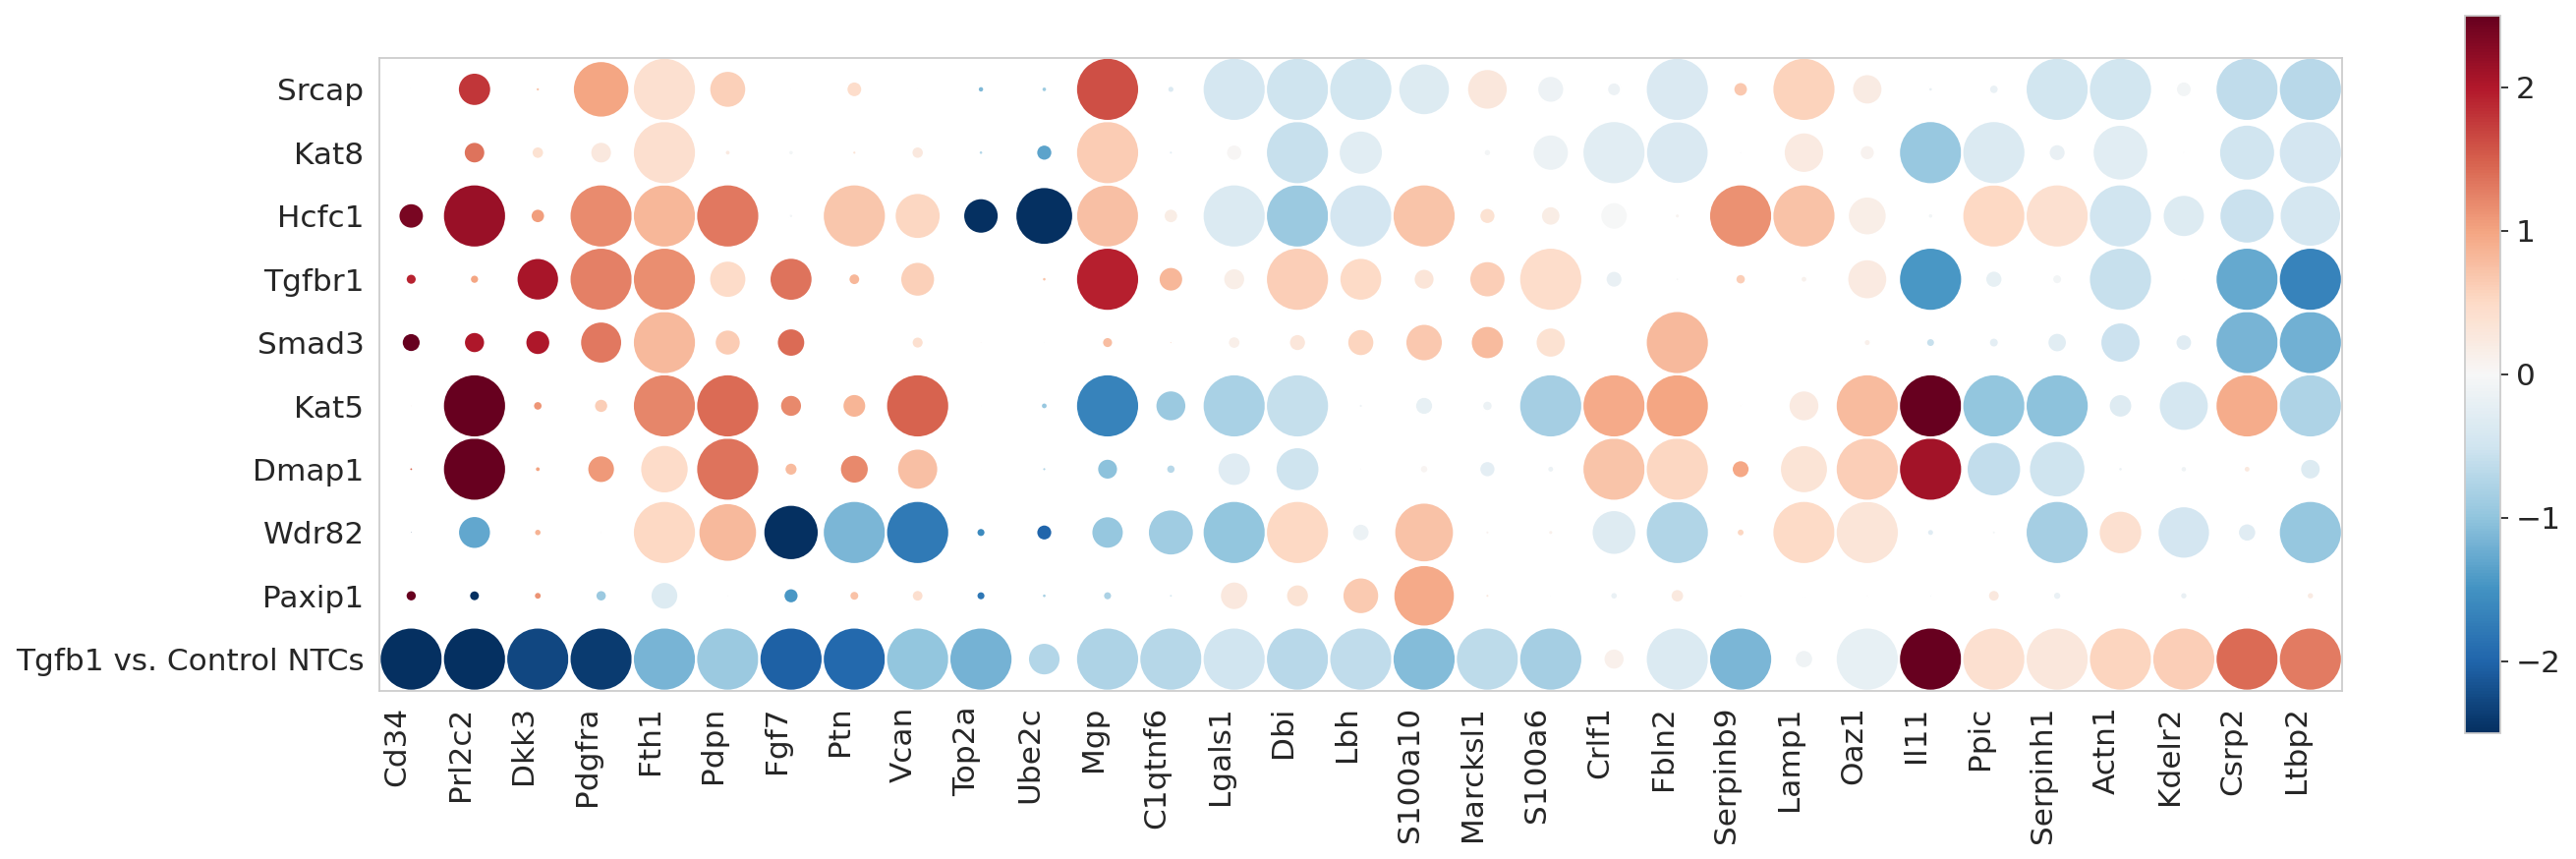

<Figure size 768x576 with 0 Axes>

In [88]:
GeneList = load_up_genes(path = 'DL_MarkerGenes2.csv', ref_genes = adata.var.index, set_num = 0)
yy_T_tmp = trim_for_plot(yy_T, GeneList, ct_ntc)
yy_NTC_tmp = trim_for_plot(yy_NTC, GeneList, ['Tgfb1'])
yy_NTC_tmp.group = 'Tgfb1 vs. Control NTCs'
yy_plt = pd.concat([ yy_T_tmp,yy_NTC_tmp], axis=0)

heatmap_circle(fig_size = (20,6), method="ward", vmin=-2.5, vmax=2.5, row_cluster=True, col_cluster=True,
               input_colors = yy_plt.pivot(index='group', columns='names', values='logfoldchanges'),
               input_sizes = yy_plt.pivot(index='group', columns='names', values='log_pval')               
              )
#plt.savefig("figures/DEG_signature_mapping_Tgfb1_geneset0.png", dpi=600)
#plt.savefig("figures/DEG_signature_mapping_Tgfb1_geneset0.svg", dpi=600)
plt.show()
plt.clf()

Num of genes already QCd out
20
Number of genes to plot
29


<Figure size 800x800 with 0 Axes>

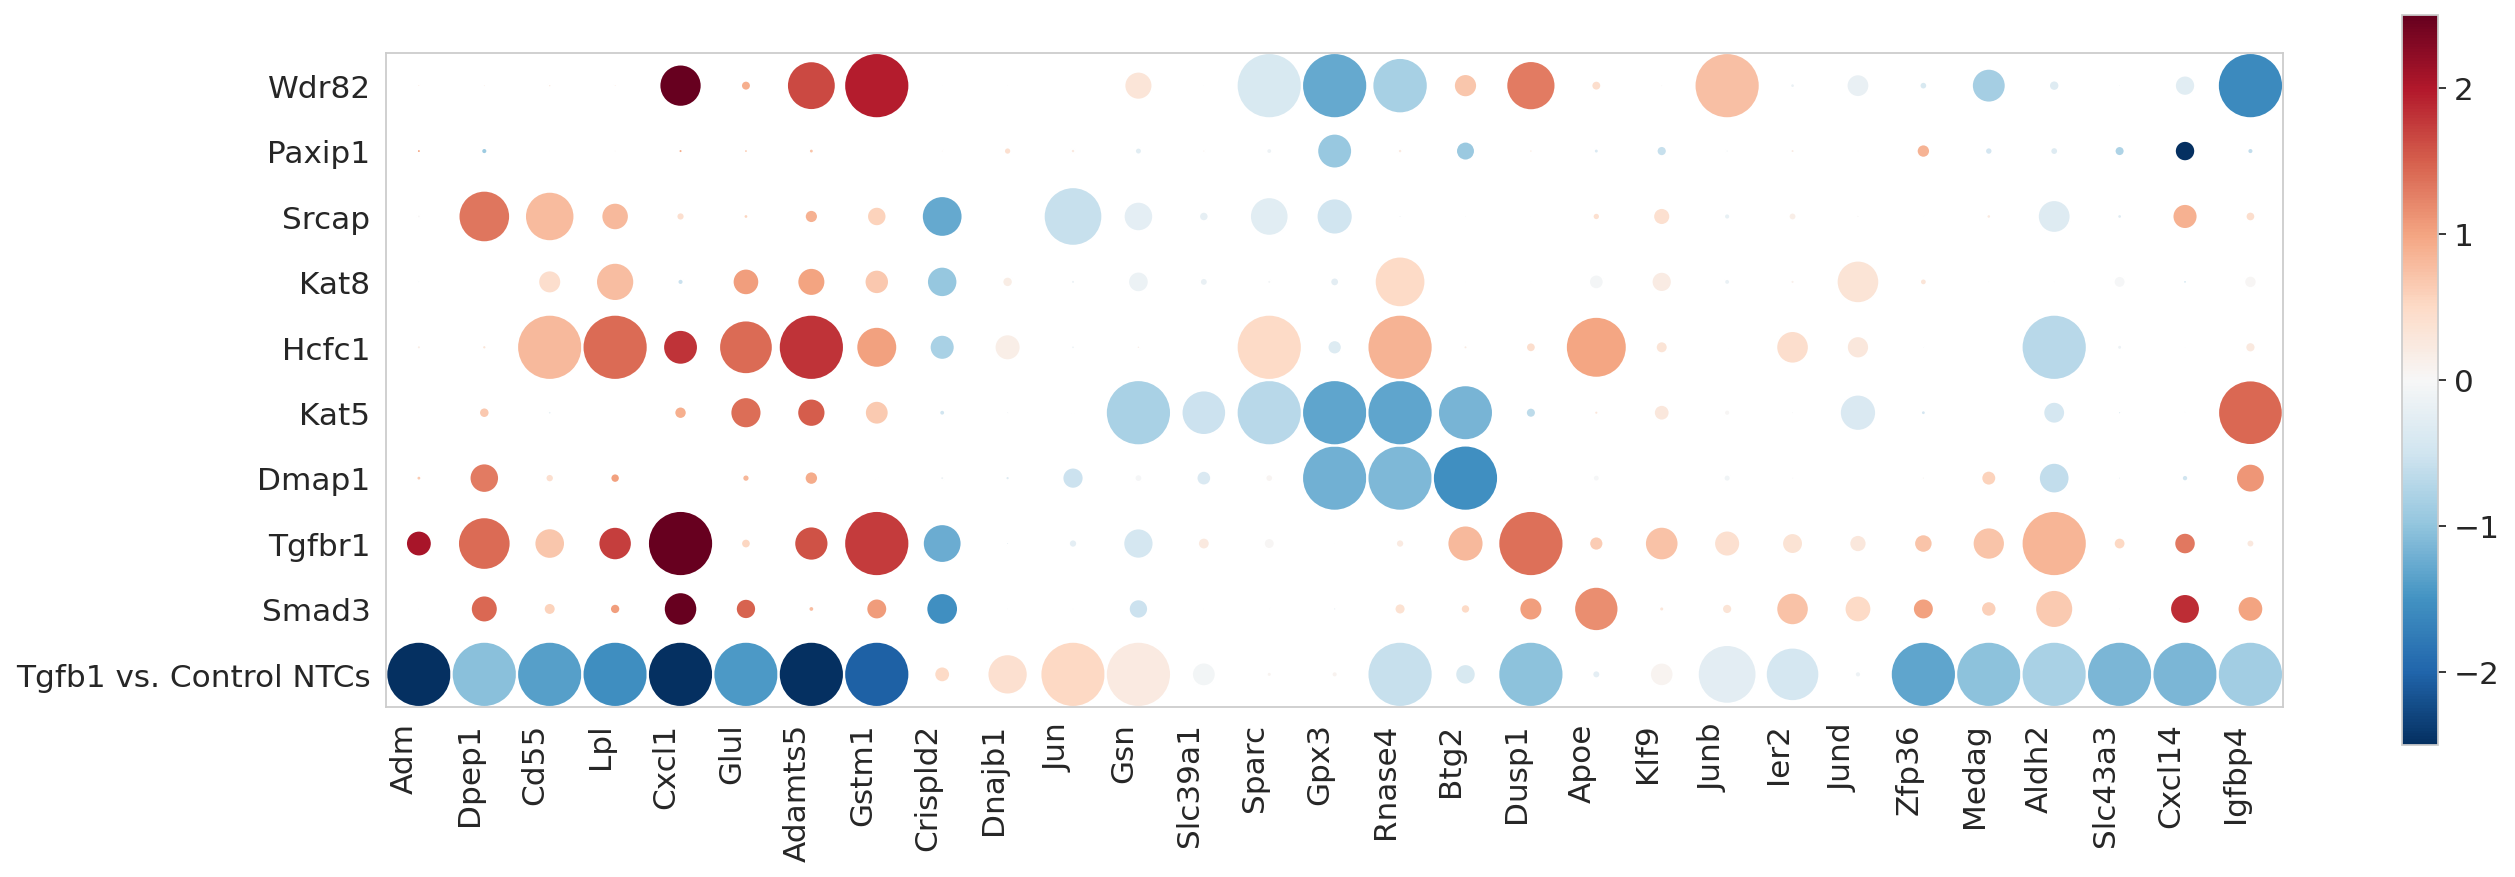

<Figure size 768x576 with 0 Axes>

In [89]:
GeneList = load_up_genes(path = 'DL_MarkerGenes2.csv', ref_genes = adata.var.index, set_num = 1)
yy_T_tmp = trim_for_plot(yy_T, GeneList, ct_ntc)
yy_NTC_tmp = trim_for_plot(yy_NTC, GeneList, ['Tgfb1'])
yy_NTC_tmp.group = 'Tgfb1 vs. Control NTCs'
yy_plt = pd.concat([ yy_T_tmp,yy_NTC_tmp], axis=0)

heatmap_circle(fig_size = (19,6), method="ward", vmin=-2.5, vmax=2.5, row_cluster=True, col_cluster=True,
               input_colors = yy_plt.pivot(index='group', columns='names', values='logfoldchanges'),
               input_sizes = yy_plt.pivot(index='group', columns='names', values='log_pval')               
              )
plt.savefig("figures/DEG_signature_mapping_Tgfb1_geneset1.png", dpi=600)
plt.savefig("figures/DEG_signature_mapping_Tgfb1_geneset1.svg", dpi=600)
plt.show()
plt.clf()

Num of genes already QCd out
1
Number of genes to plot
64


<Figure size 800x800 with 0 Axes>

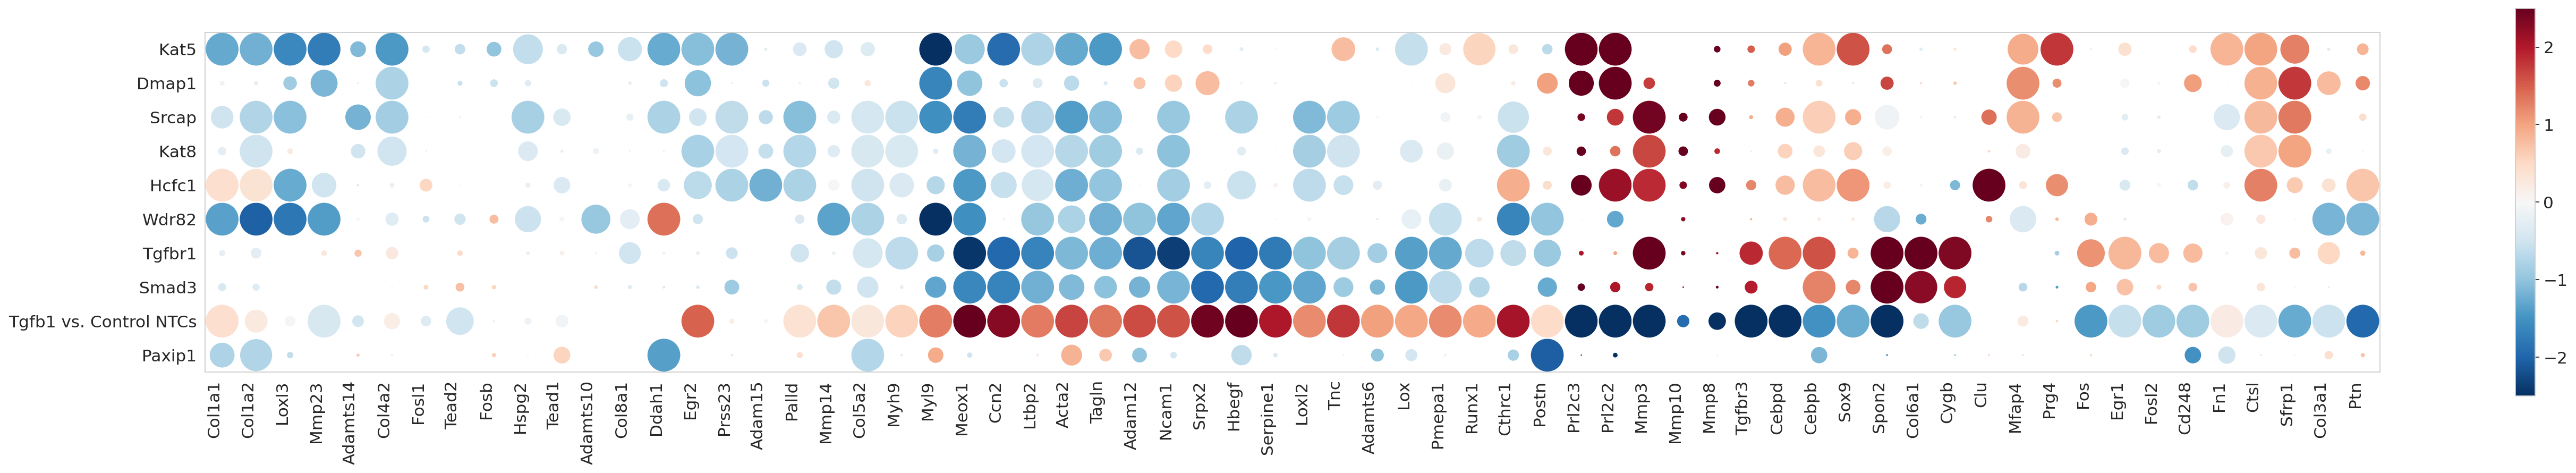

<Figure size 768x576 with 0 Axes>

In [90]:
GeneList = load_up_genes(path = 'DL_MarkerGenes2.csv', ref_genes = adata.var.index, set_num = 2)
yy_T_tmp = trim_for_plot(yy_T, GeneList, ct_ntc)
yy_NTC_tmp = trim_for_plot(yy_NTC, GeneList, ['Tgfb1'])
yy_NTC_tmp.group = 'Tgfb1 vs. Control NTCs'
yy_plt = pd.concat([ yy_T_tmp,yy_NTC_tmp], axis=0)

heatmap_circle(fig_size = (41,6), method="ward", vmin=-2.5, vmax=2.5, row_cluster=True, col_cluster=True,
               input_colors = yy_plt.pivot(index='group', columns='names', values='logfoldchanges'),
               input_sizes = yy_plt.pivot(index='group', columns='names', values='log_pval')               
              )
#plt.savefig("figures/DEG_signature_mapping_Tgfb1_geneset2.png", dpi=600)
#plt.savefig("figures/DEG_signature_mapping_Tgfb1_geneset2.svg", dpi=600)
plt.show()
plt.clf()

Num of genes already QCd out
1
Number of genes to plot
39


<Figure size 800x800 with 0 Axes>

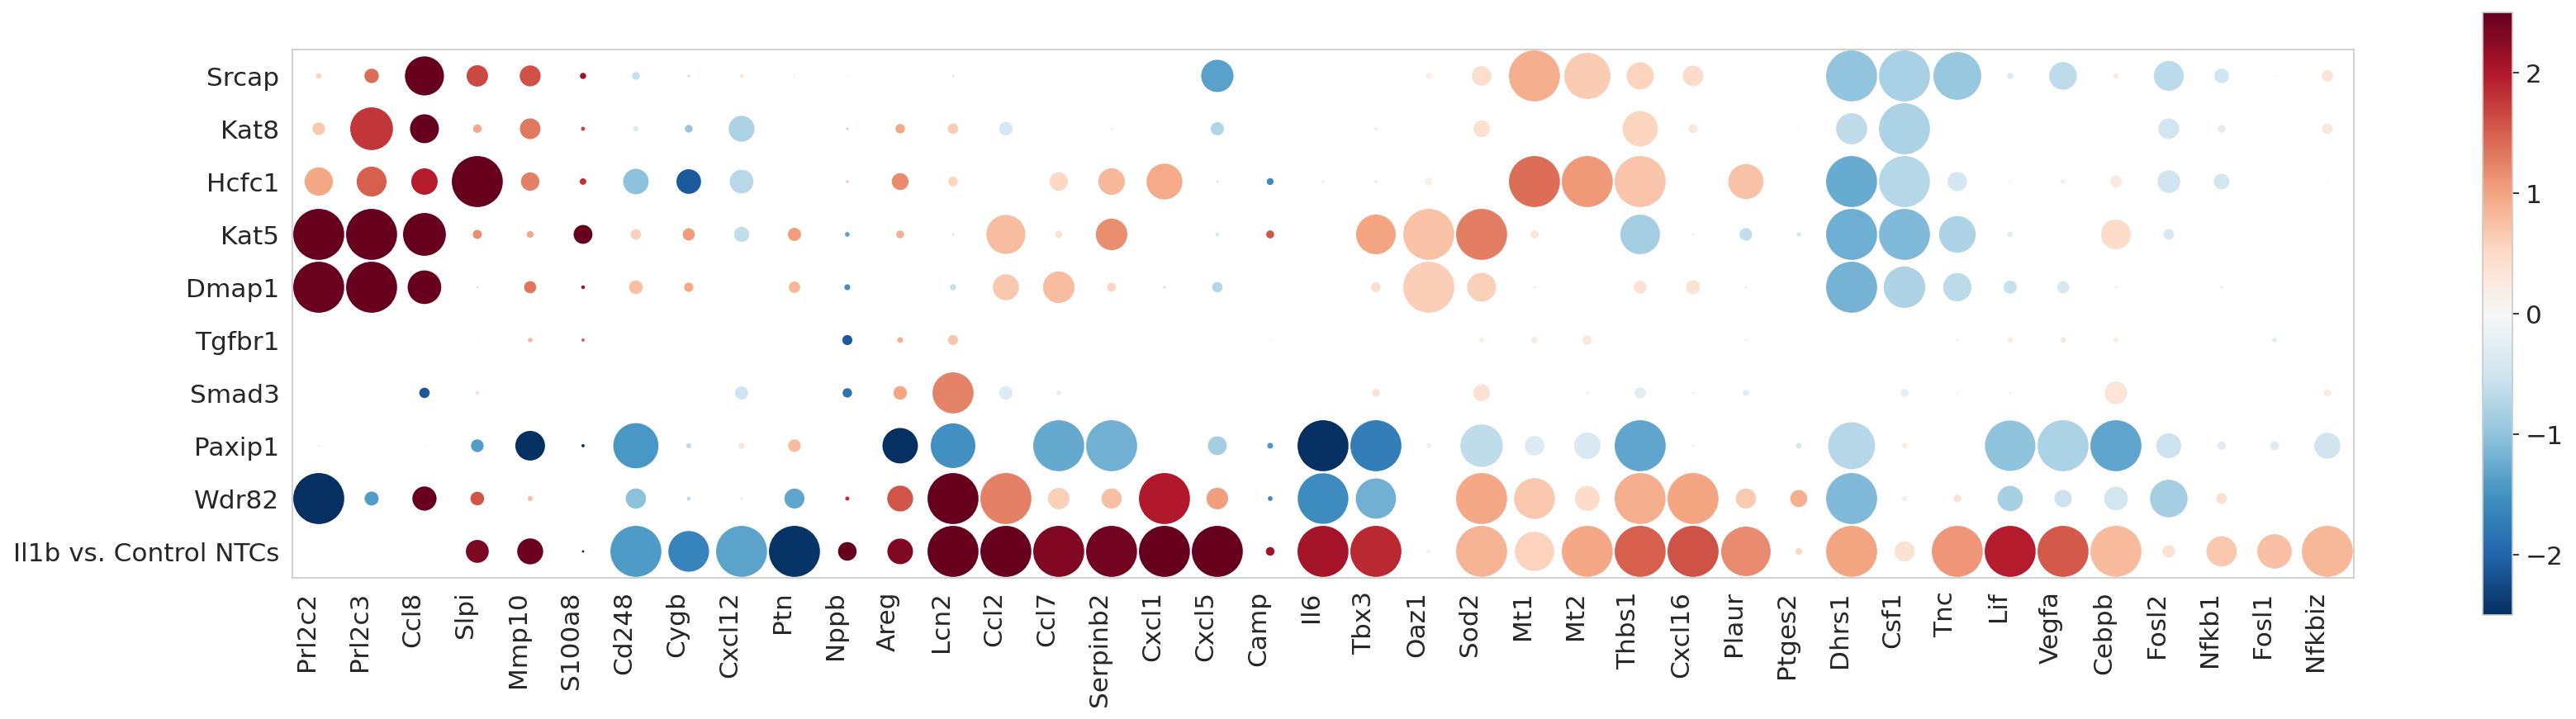

<Figure size 768x576 with 0 Axes>

In [91]:
GeneList = load_up_genes(path = 'DL_MarkerGenes2.csv', ref_genes = adata.var.index, set_num = 3)
yy_I_tmp = trim_for_plot(yy_I, GeneList, ct_ntc)
yy_NTC_tmp = trim_for_plot(yy_NTC, GeneList, ['Il1b'])
yy_NTC_tmp.group = 'Il1b vs. Control NTCs'
yy_plt = pd.concat([ yy_I_tmp,yy_NTC_tmp], axis=0)

heatmap_circle(fig_size = (25,6), method="ward", vmin=-2.5, vmax=2.5, row_cluster=True, col_cluster=True,
               input_colors = yy_plt.pivot(index='group', columns='names', values='logfoldchanges'),
               input_sizes = yy_plt.pivot(index='group', columns='names', values='log_pval')               
              )

plt.savefig("figures/DEG_signature_mapping_Il1b_geneset3.png", dpi=600)
plt.savefig("figures/DEG_signature_mapping_Il1b_geneset3.svg", dpi=600)
plt.show()
plt.clf()